SF2935 Project on: Viability of Classifying Exoplanets from Limited Data with Machine Learning
by Emil Takman
Github copilot has been used as an aid in the making of this.

In [ ]:
from sklearn.preprocessing import StandardScaler
from difflib import SequenceMatcher

In [ ]:
class Table_entry():
    def __init__(self, data):
        self.pl_name = data[0]
        self.hostname = data[1]
        self.sy_snum = data[2]
        self.sy_pnum = data[3]
        self.discoverymethod = data[4]
        #self.disc_year = data[5]
        #self.disc_facility = data[6]
        #self.pl_controv_flag = data[7]
        self.pl_orbper = data[8]
        self.pl_orbsmax = data[9]
        #self.pl_rade = data[10]
        self.pl_radj = data[11]
        #self.pl_bmasse = data[12]
        self.pl_bmassj = data[13]
        #self.pl_bmassprov = data[14]
        self.pl_orbeccen = data[15]
        self.pl_insol = data[16]
        self.pl_eqt = data[17]
        #self.ttv_flag = data[18]
        #self.st_spectype = data[19]
        #self.st_teff = data[20]
        self.st_rad = data[21]
        self.st_mass = data[22]
        self.st_met = data[23]
        self.st_metratio = data[24]
        #self.st_logg = data[25]
        #self.rastr = data[26]
        #self.ra = data[27]
        #self.decstr = data[28]
        #self.dec = data[29]
        #self.sy_dist = data[30]
        #self.sy_vmag = data[31]
        #self.sy_kmag = data[32]
        #self.sy_gaiamag = data[33]
        self.label = None
        self.convert_to_numeric()
    
    def convert_to_numeric(self): #converts numeric parameters to float and int datatype
        for attr, value in self.__dict__.items():
            if value == '':
                setattr(self, attr, None)
            elif value:
                try:
                    if '.' in value:
                        setattr(self, attr, float(value))
                    else:
                        setattr(self, attr, int(value))
                except ValueError:
                    pass

    def similar_name(self, name):
        if self.label != None:
            return 0
        return SequenceMatcher(None, self.pl_name.lower(), name.lower()).ratio()
    
    def get_non_numeric_attributes(self): #finds all relevant non numeric attributes
        non_numeric_attrs = []
        for attr, value in self.__dict__.items():
            if attr not in ['hostname', 'pl_name'] and not isinstance(value, (int, float)) and value != None:
                non_numeric_attrs.append([attr, value])
        return non_numeric_attrs
    
    
    def get_attributes(self,attrs): #returns a list of specified attributes
        if attrs == 'all':
            return list(self.__dict__.values())
        elif attrs == "numeric":
            return [value for value in self.__dict__.values() if isinstance(value, (int, float)) or value is None]
        return [self.__dict__[attr] for attr in attrs]
    
    def set_numeric(self, attr_value_list): #replaces non-numeric attributes with numeric values representing indexes in numeric_rep
        for parameter in attr_value_list:
            attr = parameter[0]
            value = parameter[1]
            if attr in self.__dict__.keys():
                setattr(self, attr, value)
            else:
                print(f"Attribute {attr} not found in Table_entry.")
        

class Numeric_representation(): #keeps track of the true values for non numeric parameters that have been converted to numeric
    def __init__(self):
        self.attr_names = []
        self.values = []

    def make_numeric(self, data_set): #converts all necessary non-numeric attributes in data_set to numeric values
        for entry in data_set:
            non_num = entry.get_non_numeric_attributes()
            if len(non_num) > 0:
                attr_value_list = []
                for i in range(len(non_num)):
                    parameter = non_num[i]
                    
                    attr = parameter[0]
                    value = parameter[1]
                    if attr not in self.attr_names:
                        #print(f"New attribute found: {attr}")
                        self.attr_names.append(attr)
                        self.values.append([value])
                        attr_value_list.append([attr, 0])
                    elif value not in self.values[self.attr_names.index(attr)]:
                        self.values[self.attr_names.index(attr)].append(value)
                        #print(f"New value '{value}' found for attribute '{attr}'")
                        attr_value_list.append([attr, len(self.values[self.attr_names.index(attr)])-1])
                    else:
                        attr_value_list.append([attr, self.values[self.attr_names.index(attr)].index(value)])
                entry.set_numeric(attr_value_list)


    def get_actual_value(self, attr, index): #given an attribute name and an index returns the actual value
        if attr in self.attr_names:
            if index < len(self.values[self.attr_names.index(attr)]):
                return self.values[self.attr_names.index(attr)][index]
            else:
                print(f"Index {index} out of range for attribute {attr}.")
        else:
            print(f"Attribute {attr} not found.")
        return None


Reads dataset

In [ ]:
import csv
path = 'C:\\Users\\emil_\\OneDrive\\Dokument\\KTH\\modern_methods_in_statistical_learning\\pure_data.csv'
full_data = []
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        full_data.append(Table_entry(row))

print("Number of exoplanets in dataset: " + str(len(full_data)))

Number of exoplanets in dataset: 5989


Adds labels to exoplanets

In [4]:
# import the labels and assign them
labels_txt_arr = ['terrestrial.txt', 'super_earth.txt', 'neptune_like.txt', 'gas_giant.txt']
labels_arr = ['terrestrial', 'super_earth', 'neptune_like', 'gas_giant']
unidentified_planets = []
fails = 0
for i, label_file in enumerate(labels_txt_arr):
    with open(label_file, 'r', encoding='utf-8') as f:
        planet_names = f.read().splitlines()
        for name in planet_names:
            for entry in full_data:
                if entry.pl_name == name:  # Uses the __eq__ method defined in Table_entry
                    entry.label = labels_arr[i]
                    break
            else:
                unidentified_planets.append([name, labels_arr[i]])
                fails += 1
print(f"Total planets not found: {fails}")
# Try to find best matches for unidentified planets
for planet, label in unidentified_planets:
    best_match = None
    highest_ratio = 0.0
    for entry in full_data:
        ratio = entry.similar_name(planet)
        if ratio > highest_ratio:
            highest_ratio = ratio
            best_match = entry
    if best_match and highest_ratio > 0.4:  # Only consider matches above a certain threshold
        print(f"Best match for '{planet}' (label: {label}) is '{best_match.pl_name}' with similarity {highest_ratio:.2f}")
        best_match.label = label
        fails -= 1
    else:
        print(f"No good match found for '{planet}' (label: {label})")
print(f"Total planets not found after matching: {fails}")

Total planets not found: 139
Best match for 'Proxima Centauri d' (label: terrestrial) is 'Proxima Cen d' with similarity 0.84
Best match for 'Teegarden’s Star d' (label: terrestrial) is 'Teegarden's Star d' with similarity 0.94
Best match for 'YZ Ceti b' (label: terrestrial) is 'YZ Cet b' with similarity 0.94
No good match found for '' (label: super_earth)
No good match found for 'Debug: VIP-CLI v3.7.1, Node v18.20.1, linux 5.15.153.1-microsoft-standard-WSL2 x64' (label: super_earth)
No good match found for 'Debug: VIP-CLI v3.7.1, Node v18.20.1, linux 5.15.153.1-microsoft-standard-WSL2 x64' (label: super_earth)
Best match for 'AU Microscopii d' (label: super_earth) is 'AU Mic d' with similarity 0.67
Best match for 'Rho Coronae Borealis e' (label: super_earth) is 'rho CrB e' with similarity 0.58
No good match found for '' (label: super_earth)
No good match found for 'Debug: VIP-CLI v3.7.1, Node v18.20.1, linux 5.15.153.1-microsoft-standard-WSL2 x64' (label: super_earth)
Best match for '

Convert non numeric parameters to numeric class indicators

In [5]:
numeric_rep = Numeric_representation()

In [ ]:

numeric_rep.make_numeric(full_data)
print("Non-numeric attributes (except names) converted to numeric.")

Non-numeric attributes (except names) converted to numeric.
gas_giant
['discoverymethod', 'st_metratio', 'label']
[]
<class 'int'>


Correlation Matrix

In [7]:
import numpy as np
#correlation Matrix
complet_data_matrix = np.array([entry.get_attributes('numeric') for entry in full_data if None not in entry.get_attributes('numeric')])
correlation_matrix = np.corrcoef(complet_data_matrix, rowvar=False)
#prints corralation matrix as latex table with background color, none for < 0.7 yellow for 0.7 <= x < 0.8 red for >= 0.8 with diagonal as green
#and attribute names as headers and in first column
attribute_names = [attr for attr in full_data[0].__dict__.keys() if isinstance(full_data[0].__dict__[attr], (int, float)) or full_data[0].__dict__[attr] is None]
print("\\begin{tabular}{|" + "c|" * (len(attribute_names) + 1) + "}")
print("\\hline")
print(" & " + " & ".join(attribute_names) + " \\\\ \\hline")
for i, attr1 in enumerate(attribute_names):
    row = [attr1]
    for j, attr2 in enumerate(attribute_names):
        corr_value = correlation_matrix[i, j]
        if i == j:
            cell = f"\\cellcolor{{green!25}}{corr_value:.2f}"
        elif abs(corr_value) >= 0.8:
            cell = f"\\cellcolor{{red!25}}{corr_value:.2f}"
        elif abs(corr_value) >= 0.7:
            cell = f"\\cellcolor{{yellow!25}}{corr_value:.2f}"
        else:
            cell = f"{corr_value:.2f}"
        row.append(cell)
    print(" & ".join(row) + " \\\\ \\hline")

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
 & sy_snum & sy_pnum & discoverymethod & pl_orbper & pl_orbsmax & pl_radj & pl_bmassj & pl_orbeccen & pl_insol & pl_eqt & st_rad & st_mass & st_met & st_metratio & label \\ \hline
sy_snum & \cellcolor{green!25}1.00 & 0.03 & 0.02 & -0.02 & -0.05 & 0.22 & 0.09 & 0.11 & 0.12 & 0.13 & 0.04 & 0.06 & -0.04 & 0.00 & -0.13 \\ \hline
sy_pnum & 0.03 & \cellcolor{green!25}1.00 & -0.09 & 0.00 & 0.02 & -0.26 & -0.08 & -0.02 & -0.11 & -0.22 & -0.13 & -0.19 & -0.09 & 0.20 & 0.17 \\ \hline
discoverymethod & 0.02 & -0.09 & \cellcolor{green!25}1.00 & -0.26 & -0.24 & -0.03 & -0.07 & -0.17 & 0.04 & 0.12 & 0.09 & 0.12 & 0.03 & 0.03 & 0.02 \\ \hline
pl_orbper & -0.02 & 0.00 & -0.26 & \cellcolor{green!25}1.00 & \cellcolor{red!25}0.93 & 0.08 & 0.23 & 0.17 & -0.07 & -0.25 & 0.04 & 0.01 & 0.00 & -0.01 & -0.04 \\ \hline
pl_orbsmax & -0.05 & 0.02 & -0.24 & \cellcolor{red!25}0.93 & \cellcolor{green!25}1.00 & 0.04 & 0.18 & 0.18 & -0.13 & -0.41 & 0.07 & 0.06 

Scatter plot for mass radius

In [8]:
#scatter plot of log mass vs log radius, color by label if no label then gray
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def mass_radius_plot(data_set, labels):
    x = []
    y = []
    colours = ['blue', 'red', 'green', 'orange']
    c = []
    
    i = 0
    while i < len(labels):
        entry = data_set[i]
        if entry.pl_bmassj and entry.pl_radj:
            x.append(np.log10(entry.pl_bmassj))
            y.append(np.log10(entry.pl_radj))
            c.append(colours[labels[i]] if labels[i] is not None else 'gray')
        i += 1
    plt.scatter(x, y, c=c, alpha=0.7)
    plt.xlabel('Log Mass (Jupiter Masses)')
    plt.ylabel('Log Radius (Jupiter Radii)')
    plt.title('Planetary Mass vs Radius')
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=numeric_rep.get_actual_value('label', 0), markerfacecolor=colours[0]),
        Line2D([0], [0], marker='o', color='w', label=numeric_rep.get_actual_value('label', 1), markerfacecolor=colours[1]),
        Line2D([0], [0], marker='o', color='w', label=numeric_rep.get_actual_value('label', 2), markerfacecolor=colours[2]),
        Line2D([0], [0], marker='o', color='w', label=numeric_rep.get_actual_value('label', 3), markerfacecolor=colours[3]),
        Line2D([0], [0], marker='o', color='w', label='Unlabeled', markerfacecolor='gray')
    ]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.show()



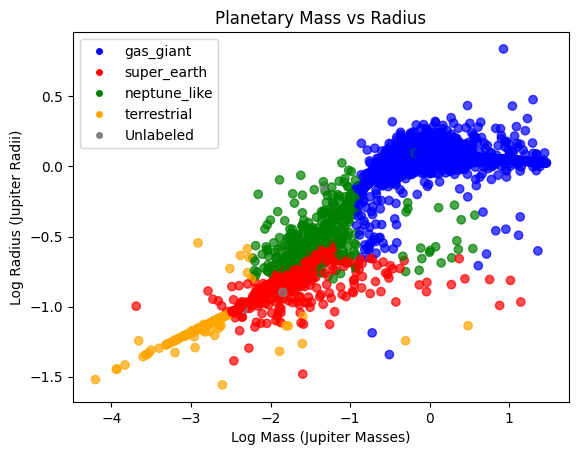

In [9]:
mass_radius_plot(full_data, [entry.label for entry in full_data])

Find sample prior distribution of labels

In [10]:
labels = np.array([0,0,0,0,0])
for entry in full_data:
    if entry.label is None:
        labels[4] += 1
    else:
        labels[entry.label] += 1

#print table of label distribution
print("\\begin{tabular}{|c|c|c|}")
print("\\hline")
print("Label & Count & Proportion \\\\")
print("\\hline")
for i in range(len(labels)-1):
    print(f"{numeric_rep.get_actual_value('label', i)} & {labels[i]} & {round(labels[i]/len(full_data), 3)} \\\\")
print(f"Unlabeled & {labels[4]} & {round(labels[4]/len(full_data), 2)} \\\\")
print("\\hline")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|}
\hline
Label & Count & Proportion \\
\hline
gas_giant & 1974 & 0.33 \\
super_earth & 1742 & 0.291 \\
neptune_like & 2035 & 0.34 \\
terrestrial & 220 & 0.037 \\
Unlabeled & 18 & 0.0 \\
\hline
\end{tabular}


Linear models

In [11]:
# LDA model function with input x and y n_folds for kfold cross validation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def lda_model(x, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = LinearDiscriminantAnalysis()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)

#QDA model

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def qda_model(x, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = QuadraticDiscriminantAnalysis()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)

#multiclass logistic model
from sklearn.linear_model import LogisticRegression
def logistic_model(x, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = LogisticRegression(max_iter=20000)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)

#perceptron model
from sklearn.linear_model import Perceptron
def perceptron_model(x, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = Perceptron()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)

Using and evaluating linear models

Non linear models

In [12]:
# SVC with adjustable parameters model
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

def svc_model(x, y, c, kernel='linear', degree=0, gamma=0, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if kernel == 'poly':
            model = SVC(C=c, kernel=kernel, degree=degree)
        elif kernel == 'rbf':
            model = SVC(C=c, kernel=kernel, gamma=gamma)
        elif kernel == 'linear':
            # Use LinearSVC for speed
            model = LinearSVC(C=c, max_iter=10000)

        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)


https://arxiv.org/abs/1603.08614
splines??

Tree-Based Methods

In [13]:
# decision tree model
from sklearn.tree import DecisionTreeClassifier

def decision_tree_model(x, y, max_depth=None, min_samples_split=2, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)

#random forest model
from sklearn.ensemble import RandomForestClassifier

def random_forest_model(x, y, n_estimators=100, max_depth=None, min_samples_split=2, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)

Neural networks

In [14]:
# neuronal network model
from sklearn.neural_network import MLPClassifier

def neural_network_model(x, y, hidden_layer_sizes=(100,), activation='relu', solver='adam', n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=1000)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)


In [15]:
## KNN
from sklearn.neighbors import KNeighborsClassifier

def knn_model(x, y, n_neighbors=5, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return np.mean(accuracies)

In [43]:
def get_input_output(subset):
    objects = []
    X = []
    y = []
    for entry in full_data:
        values = entry.get_attributes(subset)
        if None not in values:
            objects.append(entry)
            X.append(values[1:])
            y.append(values[0])
    X = np.array(X)
    X_scaled = StandardScaler().fit_transform(X)  # Standardize features
    y = np.array(y)
    objects = np.array(objects)
    return [objects, X, X_scaled, y]

testing models with different input predictors

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)



# --- Testing models with different input predictors ---
attr_arr = [
    ['label','sy_snum','sy_pnum','discoverymethod','pl_orbper','pl_orbsmax','pl_radj','pl_bmassj','pl_orbeccen','pl_insol','pl_eqt','st_rad','st_mass','st_met','st_metratio'],
    ['label','sy_snum','pl_orbper','pl_insol','st_rad','st_mass','st_met','st_metratio'],
    ['label', 'pl_orbper', 'pl_insol', 'st_mass', 'st_met', 'st_metratio'],
    ['label', 'pl_orbper', 'st_mass', 'st_met', 'st_metratio'],
    ['label','sy_snum', 'pl_orbper', 'pl_insol', 'st_mass', 'st_met', 'st_metratio'],
    ['label','sy_snum', 'pl_orbper', 'st_mass', 'st_met', 'st_metratio'],
    ['label', 'pl_radj', 'pl_bmassj'],
    ['label','sy_snum','st_mass','st_met','st_metratio']
]


for attr in attr_arr:
    print("\nTesting with attributes:", attr)
    
    [objects, X, X_scaled, y] = get_input_output(attr)

    # --- Models with timeout ---

    print("LDA accuracy:", lda_model(X_scaled, y))
    print("QDA accuracy:", qda_model(X_scaled, y))
    print("Logistic Regression accuracy:", logistic_model(X_scaled, y))
    print("Perceptron accuracy:", perceptron_model(X_scaled, y))


    print("SVC accuracy (linear):", svc_model(X_scaled, y, c=1, kernel='linear'))
    print("SVC accuracy (poly):", svc_model(X_scaled, y, c=1, kernel='poly', degree=2))
    print("SVC accuracy (rbf):", svc_model(X_scaled, y, c=1, kernel='rbf', gamma='scale'))

    print("Decision Tree accuracy:", decision_tree_model(X, y, max_depth=5))
    print("Random Forest accuracy:", random_forest_model(X, y, n_estimators=100, max_depth=5))

    print("NN accuracy (50,25):", neural_network_model(X_scaled, y, hidden_layer_sizes=(50, 25), activation='relu', solver='adam'))
    print("NN accuracy (100,50,25):", neural_network_model(X_scaled, y, hidden_layer_sizes=(100, 50, 25), activation='relu', solver='adam'))

    print("KNN accuracy (k=5):", knn_model(X_scaled, y, n_neighbors=5))
    print("KNN accuracy (k=10):", knn_model(X_scaled, y, n_neighbors=10))




Testing with attributes: ['label', 'sy_snum', 'pl_orbper', 'pl_insol', 'st_mass', 'st_met', 'st_metratio']
LDA accuracy: 0.5046919511884008
QDA accuracy: 0.47782643819890297
Logistic Regression accuracy: 0.5569302630699798
Perceptron accuracy: 0.42336985901975915
SVC accuracy (linear): 0.547812406990093
SVC accuracy (poly): 0.46007969240674707
SVC accuracy (rbf): 0.5608705423578504
Decision Tree accuracy: 0.552741248716843
Random Forest accuracy: 0.5803396038461305
NN accuracy (50,25): 0.5798533708308783
NN accuracy (100,50,25): 0.568025851439262
KNN accuracy (k=5): 0.5179945697399672
KNN accuracy (k=10): 0.5409155515601368

Testing with attributes: ['label', 'sy_snum', 'pl_orbper', 'st_mass', 'st_met', 'st_metratio']
LDA accuracy: 0.478017521671676
QDA accuracy: 0.41222830400253957
Logistic Regression accuracy: 0.48170840565759176
Perceptron accuracy: 0.40023604589838246
SVC accuracy (linear): 0.47024951229128364
SVC accuracy (poly): 0.4233212664895043
SVC accuracy (rbf): 0.492612599



Optimization of subsets 4 and 8 for neural network and random forest models.

In [16]:
subset4 = ['label', 'pl_orbper', 'st_mass', 'st_met', 'st_metratio']
subset8 = ['label','sy_snum','st_mass','st_met','st_metratio']

In [ ]:
import itertools
import pandas as pd


def factorial_design_matrix(parameters_low_high, subtraction=0, generators=None):
    k = len(parameters_low_high)
    base_k = k - subtraction

    # Base design: full factorial for base factors
    base_levels = [0, 1]
    design = np.array(list(itertools.product(base_levels, repeat=base_k)), dtype=int)

    # Apply generators if fractional
    if subtraction > 0 and generators:
        for sign, indices in generators:
            new_col = np.mod(np.sum(design[:, indices], axis=1), 2)
            if sign == '-':  # flip for negative generator
                new_col = 1 - new_col
            design = np.column_stack((design, new_col))
    elif subtraction > 0 and not generators:
        raise ValueError("Generators must be provided for fractional factorial designs.")

    return design



def empirical_effects(design_mat, results):
    
    X = np.array(design_mat, dtype=int)
    y = np.array(results, dtype=float)
    n_runs, n_factors = X.shape

    # Convert 0/1 coding to -1/+1 (standard effect formula)
    X_pm = 2 * X - 1

    effects = []
    factor_names = [chr(65 + i) for i in range(n_factors)]  # ['A','B','C',...]

    # --- First-order (main) effects ---
    for i, name in enumerate(factor_names):
        eff = np.mean(y * X_pm[:, i])
        effects.append((name, "main", eff))

    # --- Second-order (two-factor interactions) ---
    for (i, j) in itertools.combinations(range(n_factors), 2):
        inter_name = f"{factor_names[i]}{factor_names[j]}"
        inter_term = X_pm[:, i] * X_pm[:, j]
        eff = np.mean(y * inter_term)
        effects.append((inter_name, "interaction", eff))

    # Build DataFrame
    effects_df = pd.DataFrame(effects, columns=["Effect", "Type", "Value"])
    effects_df["AbsValue"] = effects_df["Value"].abs()
    effects_df = effects_df.sort_values("AbsValue", ascending=False).reset_index(drop=True)

    return effects_df



In [50]:
def random_forest_optimization(x, y, parameters, design_mat, objects = None, get_pred_values = False):
    row_accuracies = []
    pred_values = []
    for row in design_mat:
        n_folds = 5
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        accuracies = []
        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = RandomForestClassifier(n_estimators=parameters[0][row[0]], criterion=parameters[1][row[1]], min_samples_split=parameters[2][row[2]],
                                           min_samples_leaf=parameters[3][row[3]], max_leaf_nodes=parameters[4][row[4]])
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            accuracies.append(accuracy_score(y_test, y_pred))
            if get_pred_values:
                if get_pred_values:
                    for obj, pred in zip(objects[test_index], y_pred):
                        pred_values.append([obj, pred])

        row_accuracies.append(np.mean(accuracies))
    if get_pred_values:
        pred_values = np.array(pred_values, dtype=object)
        return pred_values
    else:
        return row_accuracies
    

Prerun values for optimization of random forest and neural network for fractional and full factorial design.

In [ ]:
rf_row_accuracies = [[np.float64(0.6066116746287354), np.float64(0.5807515919870695), np.float64(0.6056860947972617), np.float64(0.6047635871466779),
                       np.float64(0.6079047214299977), np.float64(0.5999639872129003), np.float64(0.6071660326026663), np.float64(0.6038421035563908),
                         np.float64(0.6075358890464804), np.float64(0.5720661952575768), np.float64(0.6088268877271494), np.float64(0.6080902470204113),
                           np.float64(0.6073484860121898), np.float64(0.5971927093733946), np.float64(0.6060559512410758), np.float64(0.6055046654480349),
                             np.float64(0.6097522968819071), np.float64(0.5789024804447153), np.float64(0.6108616955366332), np.float64(0.6088285944943105),
                               np.float64(0.6062411354780569), np.float64(0.5981145343171139), np.float64(0.6080887109299662), np.float64(0.608089905666979),
                                 np.float64(0.6084583966970643), np.float64(0.5783462450269072), np.float64(0.6067963468355683), np.float64(0.6117845445406492),
                                   np.float64(0.6084589087272125), np.float64(0.597744848550016), np.float64(0.6042090584960309), np.float64(0.6069808483656851)],
[np.float64(0.5005524861878453), np.float64(0.494475138121547), np.float64(0.5058931860036833), np.float64(0.5003683241252302), np.float64(0.5044198895027624),
  np.float64(0.5068139963167587), np.float64(0.49944751381215474), np.float64(0.5073664825046041), np.float64(0.5064456721915286), np.float64(0.49521178637200736),
    np.float64(0.4972375690607735), np.float64(0.5001841620626151), np.float64(0.5018416206261509), np.float64(0.5099447513812155), np.float64(0.5051565377532229),
      np.float64(0.5088397790055248), np.float64(0.49963167587476975), np.float64(0.4928176795580111), np.float64(0.5014732965009208), np.float64(0.5042357274401474),
        np.float64(0.5018416206261509), np.float64(0.5186003683241251), np.float64(0.5009208103130754), np.float64(0.5062615101289134), np.float64(0.5042357274401473),
          np.float64(0.49263351749539597), np.float64(0.49631675874769793), np.float64(0.5058931860036833), np.float64(0.501841620626151), np.float64(0.5156537753222835),
            np.float64(0.49779005524861886), np.float64(0.5047882136279928)]]

nn_row_accuracies = [[np.float64(0.597744848550016), np.float64(0.5921978552763854), np.float64(0.5916460574531962), np.float64(0.5593064039610652),
                       np.float64(0.3743544579904865), np.float64(0.3806464551299447), np.float64(0.37917197897945565), np.float64(0.4660344801101889),
                         np.float64(0.5995917412950608), np.float64(0.6021790296345982), np.float64(0.6014403408072667), np.float64(0.602178688281166),
                           np.float64(0.48354812998055996), np.float64(0.4732213352722209), np.float64(0.43293514455464466), np.float64(0.5199411848036279),
                             np.float64(0.5995902052046157), np.float64(0.6008856414799038), np.float64(0.5419670150178442), np.float64(0.5362088946463835),
                               np.float64(0.4626605427860926), np.float64(0.4439927769613742), np.float64(0.374920592657829), np.float64(0.38119227926807),
                                 np.float64(0.5990349938471043), np.float64(0.5931282140559102), np.float64(0.5569092494832761), np.float64(0.5244175230370898),
                                   np.float64(0.44234762409477335), np.float64(0.5354802757453025), np.float64(0.5399042162269181), np.float64(0.580006588121242)],
[np.float64(0.503499079189687), np.float64(0.49834254143646406), np.float64(0.4883977900552486), np.float64(0.49907918968692455), np.float64(0.5023941068139963),
  np.float64(0.5023941068139963), np.float64(0.4878453038674033), np.float64(0.48213627992633523), np.float64(0.49521178637200736), np.float64(0.4968692449355433),
    np.float64(0.48268876611418043), np.float64(0.4819521178637201), np.float64(0.4845303867403315), np.float64(0.47974217311233885), np.float64(0.4825046040515654),
      np.float64(0.4823204419889503), np.float64(0.5014732965009208), np.float64(0.49502762430939223), np.float64(0.48250460405156537), np.float64(0.4889502762430939),
        np.float64(0.498158379373849), np.float64(0.48674033149171275), np.float64(0.49005524861878447), np.float64(0.4915285451197053), np.float64(0.5023941068139963),
          np.float64(0.49502762430939223), np.float64(0.4766114180478821), np.float64(0.47182320441988956), np.float64(0.5007366482504604), np.float64(0.5011049723756906),
            np.float64(0.48287292817679556), np.float64(0.481767955801105)]]

rf_parameters_low_high = [[50, 200], #n_estimators
                       ['gini','entropy'], #criterion
                       [2,10], #min samples split
                       [1,10], #min samples leaf
                       [30,None]] #max leaf nodes

rf_design = factorial_design_matrix(rf_parameters_low_high)

nn_parameters_low_high = [[np.array([20,20]),np.array([50,100,50])], #hidden layers
                          ['relu', 'tanh'], #activation function
                          ['adam','sgd'], #optimizer
                          [0.0001, 1], #alpha
                          ['constant', 'adaptive'], #learning rate
                          [0.001,0.01], #learning rate initial
                          [200,1000]] #max iter (epochs)

generators = [('+', [0,1,2,3]), ('+', [0,1,3,4])]

nn_design = factorial_design_matrix(nn_parameters_low_high, 2, generators)

Full factoral design random forest approximate time for computation: 20 minutes, can be skipped

In [ ]:
rf_parameters_low_high = [[50, 200], #n_estimators
                       ['gini','entropy'], #criterion
                       [2,10], #min samples split
                       [1,10], #min samples leaf
                       [30,None]] #max leaf nodes

rf_design = factorial_design_matrix(rf_parameters_low_high)

rf_row_accuracies = []

for attr in [subset4, subset8]:
    [objects, X, X_scaled, y] = get_input_output(attr)
    row_accuracies = random_forest_optimization(X, y, rf_parameters_low_high, rf_design)
    print('for attributes', attr, '\n accuracies:', row_accuracies)
    rf_row_accuracies.append(row_accuracies)

for attributes ['label', 'pl_orbper', 'st_mass', 'st_met', 'st_metratio'] 
 accuracies: [np.float64(0.6066116746287354), np.float64(0.5807515919870695), np.float64(0.6056860947972617), np.float64(0.6047635871466779), np.float64(0.6079047214299977), np.float64(0.5999639872129003), np.float64(0.6071660326026663), np.float64(0.6038421035563908), np.float64(0.6075358890464804), np.float64(0.5720661952575768), np.float64(0.6088268877271494), np.float64(0.6080902470204113), np.float64(0.6073484860121898), np.float64(0.5971927093733946), np.float64(0.6060559512410758), np.float64(0.6055046654480349), np.float64(0.6097522968819071), np.float64(0.5789024804447153), np.float64(0.6108616955366332), np.float64(0.6088285944943105), np.float64(0.6062411354780569), np.float64(0.5981145343171139), np.float64(0.6080887109299662), np.float64(0.608089905666979), np.float64(0.6084583966970643), np.float64(0.5783462450269072), np.float64(0.6067963468355683), np.float64(0.6117845445406492), np.float64(0.608

In [24]:
rf_effects_subset4 = empirical_effects(rf_design,rf_row_accuracies[0])
print('subset 4')
print(rf_effects_subset4)
rf_effects_subset8 = empirical_effects(rf_design,rf_row_accuracies[1])
print('subset 8')
print(rf_effects_subset8)

subset 4
   Effect         Type     Value  AbsValue
0      DE  interaction  0.004982  0.004982
1       E         main -0.004970  0.004970
2       D         main  0.004693  0.004693
3      CD  interaction -0.003008  0.003008
4      CE  interaction  0.002592  0.002592
5       C         main  0.002026  0.002026
6       A         main  0.000698  0.000698
7      AC  interaction -0.000514  0.000514
8      BD  interaction  0.000375  0.000375
9      AE  interaction  0.000340  0.000340
10      B         main -0.000318  0.000318
11     AD  interaction  0.000283  0.000283
12     AB  interaction -0.000063  0.000063
13     BC  interaction -0.000052  0.000052
14     BE  interaction -0.000029  0.000029
subset 8
   Effect         Type     Value  AbsValue
0       C         main  0.002935  0.002935
1      CE  interaction  0.002843  0.002843
2      CD  interaction -0.001750  0.001750
3       E         main  0.001220  0.001220
4      AE  interaction  0.001082  0.001082
5      DE  interaction  0.000886  0.

In [ ]:
rf_subset4_design_mat = [[1,1,0,1,1]]
rf_subset8_design_mat = [[1,0,1,0,1]]

[objects, X, X_scaled, y] = get_input_output(subset4)

rf_sub4_accuracie = random_forest_optimization(X,y,rf_parameters_low_high, rf_subset4_design_mat)
print('subset 4 optimized', float(rf_sub4_accuracie[0]))

[objects, X, X_scaled, y] = get_input_output(subset8)
rf_sub8_accuracie = random_forest_optimization(X,y,rf_parameters_low_high, rf_subset8_design_mat)
print('subset 4 optimized', float(rf_sub8_accuracie[0]))


subset 4 optimized 0.6090122426408466
subset 4 optimized 0.5174953959484346


NN fractional factoral design, approximate time for computation: 40 minutes, can be skipped.

In [41]:
def neural_network_optimizer(x, y, parameters, design_mat, objects = None, get_pred_values = False):
    row_accuracies = []
    n_folds = 5
    pred_values = []
    for row in design_mat:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        accuracies = []
        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = MLPClassifier(hidden_layer_sizes=parameters[0][row[0]], activation=parameters[1][row[1]], solver=parameters[2][row[2]], 
                                  alpha=parameters[3][row[3]], learning_rate=parameters[4][row[4]], learning_rate_init=parameters[5][row[5]],
                                  max_iter=parameters[6][row[6]])
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            accuracies.append(accuracy_score(y_test, y_pred))
            if get_pred_values:
                if get_pred_values:
                    for obj, pred in zip(objects[test_index], y_pred):
                        pred_values.append([obj, pred])

        row_accuracies.append(np.mean(accuracies))
    if get_pred_values:
        pred_values = np.array(pred_values, dtype=object)
        return pred_values
    else:
        return row_accuracies

In [ ]:
nn_parameters_low_high = [[np.array([20,20]),np.array([50,100,50])], #hidden layers
                          ['relu', 'tanh'], #activation function
                          ['adam','sgd'], #optimizer
                          [0.0001, 1], #alpha
                          ['constant', 'adaptive'], #learning rate
                          [0.001,0.01], #learning rate initial
                          [200,1000]] #max iter (epochs)

generators = [('+', [0,1,2,3]), ('+', [0,1,3,4])]

nn_design = factorial_design_matrix(nn_parameters_low_high, 2, generators)

nn_row_accuracies = []
for attr in [subset4, subset8]:
    [objects, X, X_scaled, y] = get_input_output(attr)
    row_accuracies = neural_network_optimizer(X, y, nn_parameters_low_high, nn_design)
    print('for attributes', attr, '\n accuracies:', row_accuracies)
    nn_row_accuracies.append(row_accuracies)


In [26]:
nn_effects_subset4 = empirical_effects(nn_design, nn_row_accuracies[0])
print('subset 4')
print(nn_effects_subset4)
nn_effects_subset8 = empirical_effects(nn_design,nn_row_accuracies[1])
print('subset 8')
print(nn_effects_subset8)

subset 4
   Effect         Type     Value  AbsValue
0       C         main -0.063377  0.063377
1       B         main  0.025117  0.025117
2      BC  interaction  0.021409  0.021409
3      AC  interaction  0.013900  0.013900
4       F         main -0.013003  0.013003
5      FG  interaction  0.011503  0.011503
6      CE  interaction  0.011503  0.011503
7      EG  interaction -0.011167  0.011167
8      CF  interaction -0.011167  0.011167
9      CD  interaction  0.010879  0.010879
10     AD  interaction -0.009086  0.009086
11     BD  interaction  0.007838  0.007838
12      E         main  0.006664  0.006664
13     BG  interaction  0.006593  0.006593
14     DF  interaction -0.006100  0.006100
15      D         main -0.006013  0.006013
16     AF  interaction -0.004569  0.004569
17      G         main  0.004350  0.004350
18     BE  interaction  0.004264  0.004264
19     BF  interaction -0.003163  0.003163
20     DE  interaction  0.002735  0.002735
21     DG  interaction -0.002717  0.002717
22

The accuracies of the final models

In [ ]:
nn_subset4_design_mat = [[0,1,0,0,1,0,0]]
nn_subset8_design_mat = [[1,0,1,0,1,1,1]]

[objects, X, X_scaled, y] = get_input_output(subset4)

nn_sub4_accuracie = neural_network_optimizer(X,y,nn_parameters_low_high, nn_subset4_design_mat)
print('subset 4 optimized NN', float(nn_sub4_accuracie[0]))

[objects, X, X_scaled, y] = get_input_output(subset8)
nn_sub8_accuracie = neural_network_optimizer(X,y,nn_parameters_low_high, nn_subset8_design_mat)
print('subset 4 optimized', float(nn_sub8_accuracie[0]))

row 1 of 1
subset 4 optimized NN 0.6010696309798721
row 1 of 1
subset 4 optimized 0.5062615101289134


Displaying results with confusion matricies

In [ ]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import seaborn as sns  # optional but gives better visuals

def confusion_matrix(predicted_values, title):

    # --- Extract true and predicted numeric values ---
    true_labels = []
    pred_labels = []
    for obj, pred in predicted_values:
        true_labels.append(obj.label)
        pred_labels.append(pred)

    # --- Get class names ---
    unique_labels = sorted(set(true_labels + pred_labels))
    class_names = [numeric_rep.get_actual_value('label', val) for val in unique_labels]

    # --- Compute confusion matrix ---
    cm = sk_confusion_matrix(true_labels, pred_labels, labels=unique_labels)

    # --- Plot ---
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    

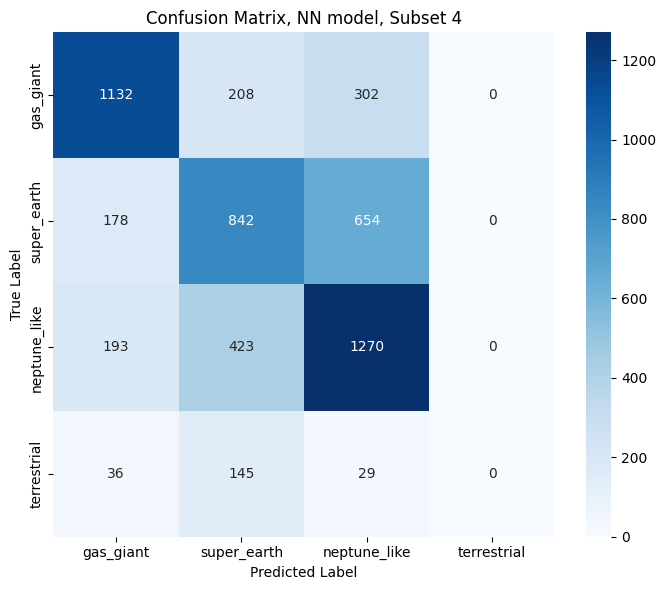

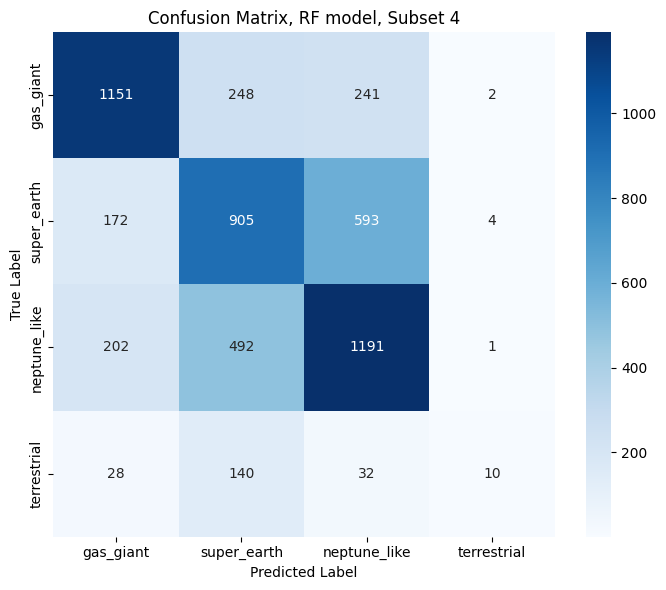

In [56]:
[objects, X, X_scaled, y] = get_input_output(subset4)
sub4_nn_pred_values = neural_network_optimizer(X,y,nn_parameters_low_high,nn_subset4_design_mat,objects,True)
confusion_matrix(sub4_nn_pred_values, 'Confusion Matrix, NN model, Subset 4')

sub4_rf_pred_values = random_forest_optimization(X,y,rf_parameters_low_high,rf_subset8_design_mat,objects,True)
confusion_matrix(sub4_rf_pred_values, 'Confusion Matrix, RF model, Subset 4')

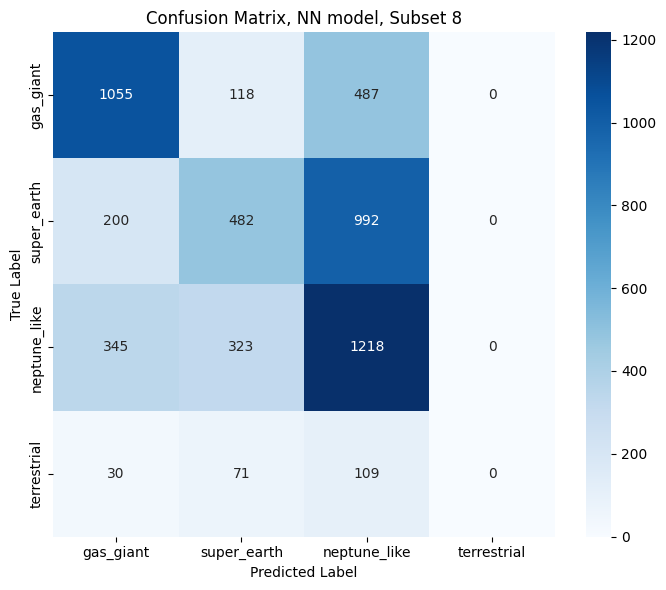

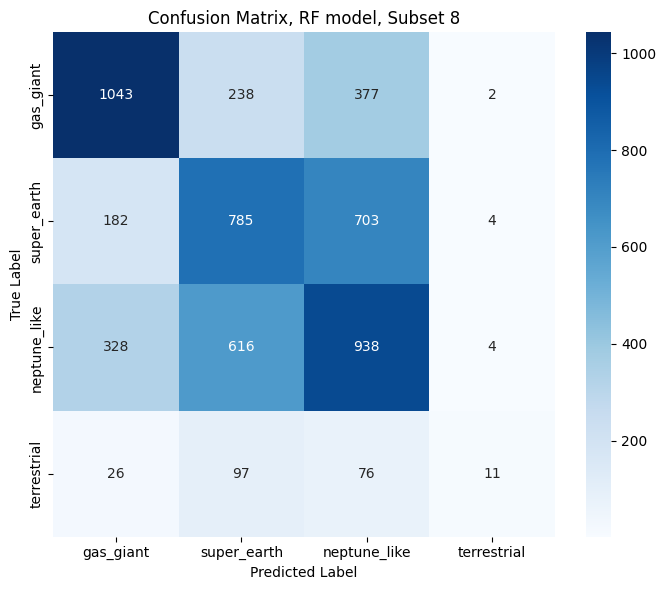

In [54]:
[objects, X, X_scaled, y] = get_input_output(subset8)
sub8_nn_pred_values = neural_network_optimizer(X,y,nn_parameters_low_high,nn_subset8_design_mat,objects,True)
confusion_matrix(sub8_nn_pred_values, 'Confusion Matrix, NN model, Subset 8')

sub8_rf_pred_values = random_forest_optimization(X,y,rf_parameters_low_high,rf_subset8_design_mat,objects,True)
confusion_matrix(sub8_rf_pred_values, 'Confusion Matrix, RF model, Subset 8')